# Ungraded Lab: Training a Single Layer Neural Network with Time Series Data

Now that you've seen statistical methods in the previous week, you will now shift to using neural networks to build your prediction models. You will start with a simple network in this notebook and move on to more complex architectures in the next weeks. By the end of this lab, you will be able to:

* build a single layer network and train it using the same synthetic data you used in the previous lab
* prepare time series data for training and evaluation
* measure the performance of your model against a validation set

## Imports

You will first import the packages you will need to execute all the code in this lab. You will use:
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) to build your model and prepare data windows
* [Numpy](https://numpy.org/) for numerical processing
* and Matplotlib's [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) library for visualization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-10-03 07:04:12.923635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 07:04:12.931459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 07:04:12.940579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 07:04:12.943221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 07:04:12.950259: I tensorflow/core/platform/cpu_feature_guar

## Utilities

You will then define some utility functions that you also saw in the previous labs. These will take care of visualizing your time series data and model predictions, as well as generating the synthetic data.

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

The code below generates the same synthetic data you used in the previous lab. It will contain 1,461 data points that has trend, seasonality, and noise.

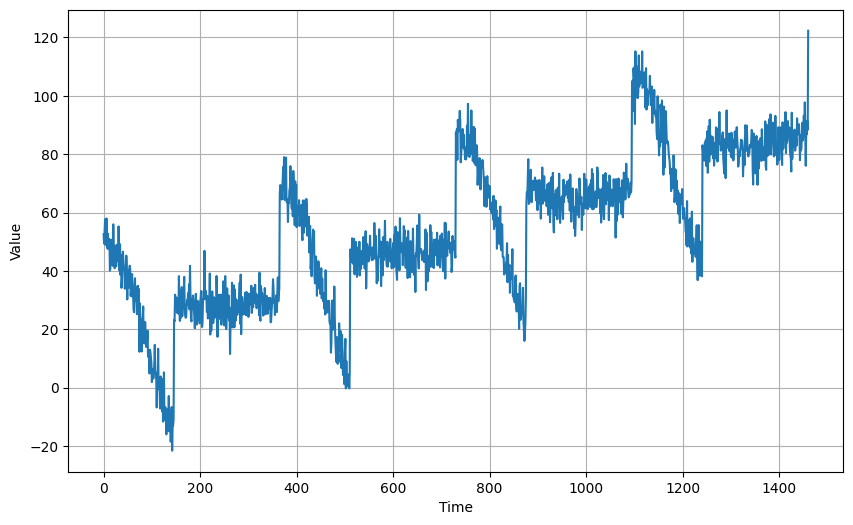

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

Next up, you will split the data above into training and validation sets. You will take the first 1,000 points for training while the rest is for validation.

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

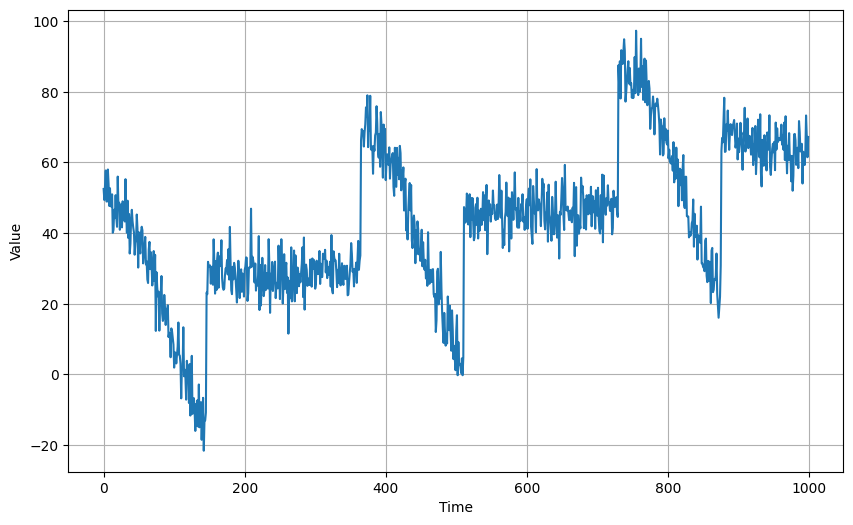

In [5]:
# Plot the train set
plot_series(time_train, x_train)

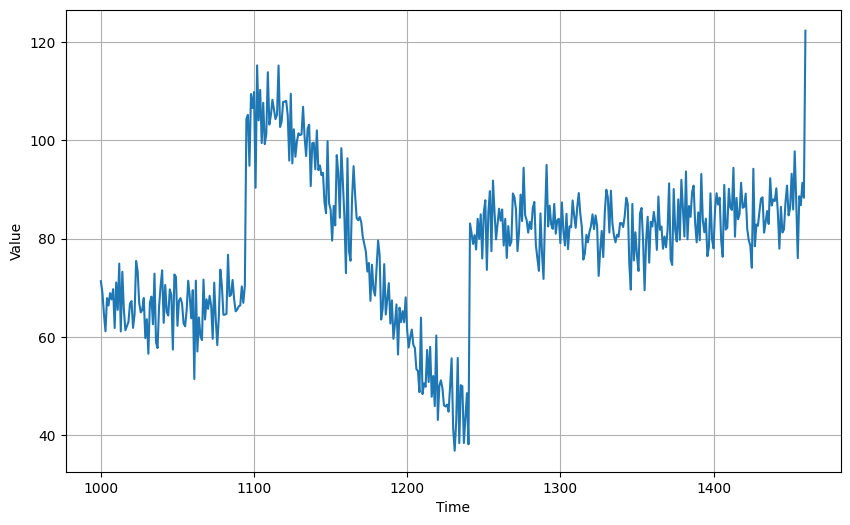

In [6]:
# Plot the validation set
plot_series(time_valid, x_valid)

## Prepare features and labels

You will then prepare your data windows as shown in the previous lab. It is good to declare parameters in a separate cell so you can easily tweak it later if you want.

In [7]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

The following function contains all the preprocessing steps you did in the previous lab. This makes it modular so you can easily use it in your other projects if needed. 

One thing to note here is the `window_size + 1` when you call `dataset.window()`. There is a `+ 1` to indicate that you're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

Now you can generate the dataset windows from the train set.

In [9]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-10-03 07:15:21.232630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


You can again inspect the output to see if the function is behaving as expected. The code below will use the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method of the `tf.data.Dataset` API to grab a single batch. It will then print several properties of this batch such as the data type and shape of the elements. As expected, it should have a 2-element tuple (i.e. `(feature, label)`) and the shapes of these should align with the batch and window sizes you declared earlier which are `32` and `20` by default, respectively.

In [10]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


2024-10-03 07:15:25.604400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-03 07:15:25.604690: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit [Dense](https://keras.io/api/layers/core_layers/dense/) layer as shown below. You will assign the layer to a variable `l0` so you can also look at the final weights later using the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method.

In [11]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    l0
])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.2821419 ],
       [ 0.40561527],
       [ 0.04202592],
       [ 0.40389955],
       [-0.09989199],
       [-0.2616693 ],
       [-0.06795081],
       [ 0.2567147 ],
       [ 0.46632224],
       [-0.20957229],
       [ 0.29005468],
       [-0.25473845],
       [ 0.13417137],
       [ 0.13356256],
       [ 0.350362  ],
       [ 0.00971168],
       [-0.37105125],
       [-0.46805865],
       [-0.40454274],
       [-0.29945564]], dtype=float32), array([0.], dtype=float32)] 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

You will set [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) as the loss function and use [*stochastic gradient descent (SGD)*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) to optimize the weights during training.

In [12]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

## Train the Model

Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [13]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100


I0000 00:00:1727964943.935235 2199987 service.cc:146] XLA service 0x70cc80006020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727964943.935256 2199987 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-03 07:15:43.956401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-03 07:15:44.089610: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1552.7378
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 381.9726
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 228.7015
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 181.0509
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 151.5257
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 133.1973
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 120.6868
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 111.7039
Epoch 9/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129.5434

I0000 00:00:1727964944.138573 2199987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-03 07:15:44.212382: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-03 07:15:44.212417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.212432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
/home/codingfreak/anaconda3/envs/tf-gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-03 0

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 104.8438
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 99.3397
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 94.7451
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 90.7982
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 87.3391
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 84.2656
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 81.5088
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 79.0197
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 76.7611
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 74.7038
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 72.8238
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 71.1011
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 69.5184
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 68.0609
Epoch 23/100
31/31 ━━━━━━━━━━━━━

2024-10-03 07:15:44.341753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.341794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.353299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.353319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.364956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.364976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.377374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 63.2456
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 62.2481
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 61.3179
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 60.4488
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 59.6355
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 58.8730
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 58.1571
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 57.4838
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 56.8498
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 56.2520
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 55.6874
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 55.1538
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 54.6486
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 54.1701
Epoch 40/100
31/31 ━━━━━━━━━━━━━━

2024-10-03 07:15:44.543797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.543810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.555219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.555233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.567186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.567199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.579126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 52.4862
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 52.1155
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 51.7624
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 51.4257
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 51.1046
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 50.7981
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 50.5054
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 50.2256
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 49.9581
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 49.7022
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 49.4572
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 49.2227
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 48.9979
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 48.7826
Epoch 57/100
31/31 ━━━━━━━━━━━━━━

2024-10-03 07:15:44.749267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.749280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.760714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.760728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.773025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.773038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.784464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 47.8302
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - loss: 47.6619
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - loss: 47.5002
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 47.3448
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 47.1953
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 47.0516
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 46.9134
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 46.7804
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 46.6524
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 46.5291
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 46.4105
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 46.2962
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 46.1861
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 46.0800
Epoch 75/100
31/31 ━

2024-10-03 07:15:44.961734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.961739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.972593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.972607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.983415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:44.983428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:44.995741: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abort

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 45.7841
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 45.6925
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - loss: 45.6041
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 45.5188
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 45.4365
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 45.3571
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 45.2805
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 45.2065
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 45.1351
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 45.0661
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 44.9995
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 44.9351
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - loss: 44.8729
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 44.8129
Epoch 91/100
31/31 ━━━━━━━━━━━━━━

2024-10-03 07:15:45.169601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:45.169626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:45.180732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:45.180746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:45.192117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:45.192130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:45.203198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - loss: 44.5919
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 44.5412
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 44.4921
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 44.4447
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 44.3988
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 44.3543
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 44.3114


2024-10-03 07:15:45.374034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:45.374040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:45.384801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:45.384807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:45.395908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6281560950913931743
2024-10-03 07:15:45.395915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3004856164808175902
2024-10-03 07:15:45.406719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

You can see the final weights by again calling the `get_weights()` method.

In [14]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-9.15294066e-02],
       [ 4.93037067e-02],
       [ 2.06710007e-02],
       [ 5.17884344e-02],
       [-3.74313677e-04],
       [-4.46733981e-02],
       [-3.03362180e-02],
       [ 3.94525342e-02],
       [ 4.51280065e-02],
       [-4.53980453e-02],
       [ 3.12561616e-02],
       [-5.94390891e-02],
       [-2.82303430e-02],
       [ 3.65260355e-02],
       [ 7.14172795e-02],
       [ 6.70543015e-02],
       [ 1.30478805e-02],
       [ 1.31782264e-01],
       [ 2.86308080e-01],
       [ 4.48782235e-01]], dtype=float32), array([0.01890964], dtype=float32)]


## Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [15]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
model prediction: [[43.133137]]


To compute the metrics, you will want to generate model predictions for your validation set. Remember that this set refers to points at index `1000` to `1460` of the entire series. You will need to code the steps to generate those from your model. The cell below demonstrates one way of doing that. 

Basically, it feeds the entire series to your model 20 points at a time and append all results to a `forecast` list. It will then slice the points that corresponds to the validation set. 

The slice index below is `split_time - window_size:` because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the `forecast` list corresponds to the prediction for time at index `20`. You cannot make predictions at index `0` to `19` because those are smaller than the window size. Thus, when you slice with `split_time - window_size:`, you will be getting the points at the time indices that aligns with those in the validation set.

*Note: You might notice that this cell takes a while to run. In the next two labs, you will see other approaches to generating predictions to make the code run faster. You might already have some ideas and feel free to try them out after completing this lab.*

In [16]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=0))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


To visualize the results, you will need to convert the predictions to a form that the `plot_series()` utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes.

shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


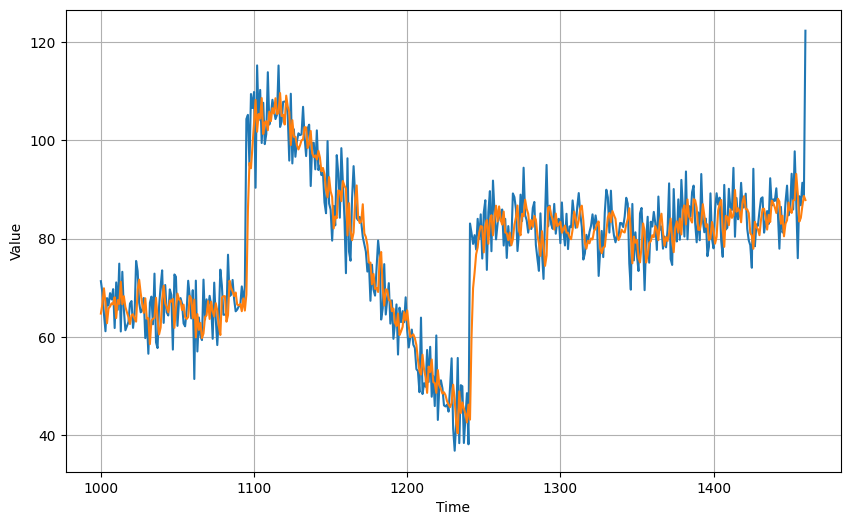

In [17]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

You can compute the metrics by calling the same functions as before. You will get an MAE close to 5.

In [18]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

45.536198
4.9779525


## Wrap Up

In this lab, you were able to build and train a single layer neural network on time series data. You prepared data windows, fed them to the model, and the final predictions show comparable results with the statistical analysis you did in Week 1. In the next labs, you will try adding more layers and will also look at some optimizations you can make when training your model.